# Term 7 project: Inventory management
### Link to Original Github Repo: https://github.com/eg4000/SKU110K_CVPR19
### SKU-110K dataset can be found here: https://www.kaggle.com/datasets/thedatasith/sku110k-annotations/data 

In [1]:
import os
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.experimental.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import dotenv

# create your own .env file and add in your directory in the format
# SKU_DATASET_DIR = r"your_directory"
# dotenv.load_dotenv()
# SKU_DATASET_DIR = os.getenv("SKU_DATASET_DIR")
sku_dataset_dir = r"C:\Users\Bloom\OneDrive\Documents\GitHub\term7cv\SKU110K_fixed"
annotations_dir = Path(sku_dataset_dir) / 'annotations'
images_path = Path(sku_dataset_dir) / 'images'

2.10.0
GPU Available: []


## Delete corrupted images
- List: https://github.com/eg4000/SKU110K_CVPR19/issues/99#issuecomment-988886374

In [2]:
CORRUPTED_IMAGES = {
    "train": (
              "train_1239.jpg",
              "train_2376.jpg",
              "train_2903.jpg",
              "train_2986.jpg",
              "train_305.jpg",
              "train_3240.jpg",
              "train_340.jpg",
              "train_3556.jpg",
              "train_3560.jpg",
              "train_3832.jpg",
              "train_38.jpg",
              "train_4222.jpg",
              "train_5007.jpg",
              "train_5137.jpg",
              "train_5143.jpg",
              "train_5762.jpg",
              "train_5822.jpg",
              "train_6052.jpg",
              "train_6090.jpg",
              "train_6138.jpg",
              "train_6409.jpg",
              "train_6722.jpg",
              "train_6788.jpg",
              "train_737.jpg",
              "train_7576.jpg",
              "train_7622.jpg",
              "train_775.jpg",
              "train_7883.jpg",
              "train_789.jpg",
              "train_8020.jpg",
              "train_8146.jpg",
              "train_882.jpg",
              "train_903.jpg",
              "train_924.jpg"
             ),
    "validation": (
              "val_147.jpg",
              "val_286.jpg",
              "val_296.jpg",
              "val_386.jpg"
             ),
    "test": (
              "test_132.jpg",
              "test_1346.jpg",
              "test_184.jpg",
              "test_1929.jpg",
              "test_2028.jpg",
              "test_22.jpg",
              "test_2321.jpg",
              "test_232.jpg",
              "test_2613.jpg",
              "test_2643.jpg",
              "test_274.jpg",
              "test_2878.jpg",
              "test_521.jpg",
              "test_853.jpg",
              "test_910.jpg",
              "test_923.jpg"
             ),             
}

for subset, filenames in CORRUPTED_IMAGES.items():
    for filename in filenames:
        file_path = os.path.join(images_path, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            #print(f"Removed: {file_path}")
        else:
            pass
            #print(f"File not found: {file_path}")


## Preprocessing
- addressing OOM issue: reduce image size(4160x2336 to 416, 233), limit batch size, use tensorflow api

In [3]:
from PIL import Image
import io

def load_and_preprocess_data(annotations_file, images_path, subset_size=0.01, img_size=(416, 233), batch_size=256):
    df = pd.read_csv(annotations_file)
    subset = "train" if "train" in str(annotations_file) else "validation" if "val" in str(annotations_file) else "test"
    corrupted_images = CORRUPTED_IMAGES.get(subset, [])
    df = df[~df.iloc[:, 0].isin(corrupted_images)]
    df = df.sample(frac=subset_size, random_state=42).reset_index(drop=True)

    images_path = str(images_path)  # Convert images_path to string

    def preprocess(image_name, x1, y1, x2, y2, w, h):
        image_name = image_name.numpy().decode('utf-8')
        image_path = os.path.join(images_path, image_name)

        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)  # Resize image
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]

        x1, x2 = x1 / w, x2 / w
        y1, y2 = y1 / h, y2 / h

        bbox = tf.convert_to_tensor([y1, x1, y2, x2], dtype=tf.float32)  # TensorFlow format: [ymin, xmin, ymax, xmax]
        return img, bbox

    # Convert dataframe columns to tensors
    image_names = tf.convert_to_tensor(df[df.columns[0]].values, dtype=tf.string)
    x1 = tf.convert_to_tensor(df[df.columns[1]].values.astype(float), dtype=tf.float32)
    y1 = tf.convert_to_tensor(df[df.columns[2]].values.astype(float), dtype=tf.float32)
    x2 = tf.convert_to_tensor(df[df.columns[3]].values.astype(float), dtype=tf.float32)
    y2 = tf.convert_to_tensor(df[df.columns[4]].values.astype(float), dtype=tf.float32)
    w = tf.convert_to_tensor(df[df.columns[6]].values.astype(float), dtype=tf.float32)
    h = tf.convert_to_tensor(df[df.columns[7]].values.astype(float), dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_names, x1, y1, x2, y2, w, h))
    dataset = dataset.map(lambda img, x1, y1, x2, y2, w, h: tf.py_function(preprocess, [img, x1, y1, x2, y2, w, h], [tf.float32, tf.float32]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

## Load data

In [4]:
subset_size = 0.01  # You can adjust this value as needed
img_size = (416, 233)  # Resize images to 224x224
batch_size = 64  # Number of samples per batch

train_data = load_and_preprocess_data(annotations_dir / 'annotations_train.csv', images_path, subset_size, img_size, batch_size)
val_data = load_and_preprocess_data(annotations_dir / 'annotations_val.csv', images_path, subset_size, img_size, batch_size)
test_data = load_and_preprocess_data(annotations_dir / 'annotations_test.csv', images_path, subset_size, img_size, batch_size)
print(len(train_data))

189


## Visualise data

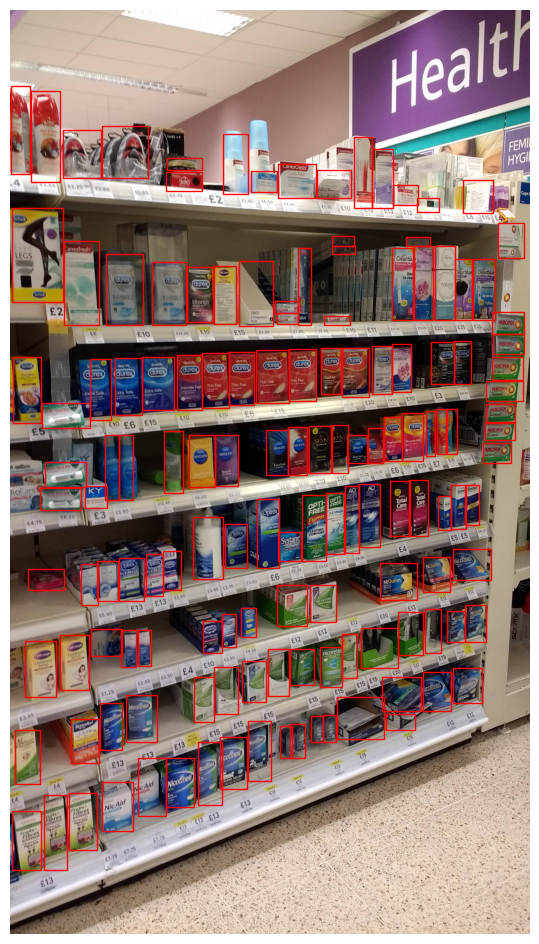

In [5]:
data_num, set = 10, 'test' 
image_num = sku_dataset_dir + rf'\images\{set}_{data_num}.jpg'
annotations_dir = Path(sku_dataset_dir) / 'annotations'
annotation_set_df = pd.read_csv("C:/Users/Bloom/OneDrive/Documents/GitHub/term7cv/SKU110K_fixed" + f'/annotations/annotations_{set}.csv')
annotation_num = annotation_set_df[annotation_set_df.iloc[:, 0] == f'{set}_{data_num}.jpg']

def display_image_with_annotations(image_path, annotations_df):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)

    # Add the bounding boxes
    for index, row in annotations_df.iterrows():
        x1, y1, x2, y2 = row[1], row[2], row[3], row[4]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Display the image with annotations
display_image_with_annotations(image_num, annotation_num)

## Train

In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception, VGG19, ResNet50V2, InceptionV3, InceptionResNetV2, MobileNetV2, EfficientNetB2, VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing

## Pipeline for Multimodel Testing

In [7]:
modelsList_1 = {
    "Xception": Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "VGG19": VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet50V2": ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
}

modelList_2 = {
    "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "InceptionResNetV2": InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "EfficientNetB2": EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

In [9]:
for modelname, base_model in modelsList_1.items():
    base_model.trainable = False
    model = models.Sequential([
        Input(shape=(416, 233, 3)), 
        preprocessing.Resizing(224, 224, interpolation='bilinear'),
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(train_data, epochs=5, validation_data=val_data)
    eval_results = model.evaluate(val_data)
    print(f"Loss on validation data for {modelname}:", eval_results)

Epoch 1/5
189/189 [==============================] - 994s 5s/step - loss: 0.3134 - val_loss: 0.3186
Epoch 2/5
189/189 [==============================] - 986s 5s/step - loss: 0.3160 - val_loss: 0.3177
Epoch 3/5
189/189 [==============================] - 991s 5s/step - loss: 0.3167 - val_loss: 0.3182
Epoch 4/5
189/189 [==============================] - 985s 5s/step - loss: 0.3166 - val_loss: 0.3187
Epoch 5/5
15/15 [==============================] - 68s 4s/step - loss: 0.3187
Loss on validation data for Xception: 0.31870660185813904
Epoch 1/5
189/189 [==============================] - 2219s 12s/step - loss: 0.3165 - val_loss: 0.3108
Epoch 2/5
189/189 [==============================] - 2247s 12s/step - loss: 0.3045 - val_loss: 0.2936
Epoch 3/5
189/189 [==============================] - 2202s 12s/step - loss: 0.2998 - val_loss: 0.2936
Epoch 4/5
189/189 [==============================] - 2210s 12s/step - loss: 0.2969 - val_loss: 0.2936
Epoch 5/5
15/15 [==============================] - 155s 

In [10]:
for modelname, base_model in modelList_2.items():
    base_model.trainable = False
    model = models.Sequential([
        Input(shape=(416, 233, 3)), 
        preprocessing.Resizing(224, 224, interpolation='bilinear'),
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(train_data, epochs=5, validation_data=val_data)
    eval_results = model.evaluate(val_data)
    print(f"Loss on validation data for {modelname}:", eval_results)

Epoch 1/5
189/189 [==============================] - 705s 4s/step - loss: 0.3165 - val_loss: 0.3187
Epoch 2/5
189/189 [==============================] - 715s 4s/step - loss: 0.3078 - val_loss: 0.3043
Epoch 3/5
189/189 [==============================] - 718s 4s/step - loss: 0.3068 - val_loss: 0.3187
Epoch 4/5
189/189 [==============================] - 720s 4s/step - loss: 0.3165 - val_loss: 0.3187
Epoch 5/5
15/15 [==============================] - 52s 3s/step - loss: 0.3187
Loss on validation data for InceptionV3: 0.31870660185813904
Epoch 1/5
189/189 [==============================] - 1218s 6s/step - loss: 0.3051 - val_loss: 0.3043
Epoch 2/5
189/189 [==============================] - 1232s 7s/step - loss: 0.3039 - val_loss: 0.3043
Epoch 3/5
189/189 [==============================] - 1241s 7s/step - loss: 0.3047 - val_loss: 0.3043
Epoch 4/5
189/189 [==============================] - 1280s 7s/step - loss: 0.3046 - val_loss: 0.3043
Epoch 5/5
15/15 [==============================] - 160s 1

# VGG16 Implementation

In [ ]:
base_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the VGG16 layers

model = models.Sequential([
    Input(shape=(416, 233, 3)), 
    preprocessing.Resizing(224, 224, interpolation='bilinear'),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(train_data, epochs=5, validation_data=val_data)
eval_results = model.evaluate(val_data)
print("Loss on validation data:", eval_results)

# ResNet50 Implementation

In [ ]:
base_model_2 = ResNet50(
    weights="imagenet",
    include_top=False, # use our own input layer for transfer learning
    input_shape=(224, 224, 3)
)

base_model_2.trainable = False

resnet_model = models.Sequential([
    Input(shape=(416, 233, 3)), 
    preprocessing.Resizing(224, 224, interpolation='bilinear'),
    base_model_2,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
])

resnet_model.summary()  # display model details
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
history = resnet_model.fit(train_data, epochs=5, validation_data=val_data)
eval_results = model.evaluate(val_data)
print("Loss on validation data:", eval_results)